In [37]:
# (Optionnel) Installer mord dans l'environnement du kernel Jupyter
# Si mord est déjà installé, cette cellule ne fait rien.

import importlib.util, sys

if importlib.util.find_spec("mord") is None:
    !{sys.executable} -m pip install mord
else:
    print("mord déjà installé ✅")


mord déjà installé ✅


# Prédiction de la consommation (conso_5_usages_ef) via **régression logistique ordinale**

Objectif : prédire une **consommation estimée** à partir des caractéristiques du logement, en utilisant une **régression logistique ordinale**.

Comme l’ordinal logit prédit des **classes ordonnées**, on procède en 3 étapes :
1. Discrétiser la conso en **K bins ordonnés** (calculés **sur le train uniquement**).
2. Apprendre un modèle **ordinal logit** sur ces classes.
3. Reconstruire une conso continue via une valeur **robuste par classe** (médiane par bin, côté train).


In [38]:
# =========================
# Paramètres du modèle
# =========================
# K = nombre de bins (classes ordinales). Ex: 5 / 7 / 10
# alpha = régularisation du modèle ordinal (mord.LogisticAT)
K = 12 # utilise le paramètre défini plus haut
ALPHA = 0.3

RANDOM_SEED = 42


In [39]:
import pandas as pd
import numpy as np
import mord

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from pathlib import Path

# --- Chargement du dataset (chemin robuste) ---
csv_path = Path("../../data/processed/DPE.csv")

if not csv_path.exists():
    # aide debug si le notebook est lancé depuis un autre dossier
    import os
    raise FileNotFoundError(
        f"CSV introuvable: {csv_path.resolve()}\n"
        f"cwd = {os.getcwd()}\n"
        f"Astuce: ajuste le chemin vers data/processed/DPE.csv"
    )

df = pd.read_csv(csv_path)
print("Dataset shape:", df.shape)


Dataset shape: (8787, 14)


In [40]:
# Target
TARGET = "conso_5_usages_ef"

if TARGET not in df.columns:
    # debug utile
    cols_like = [c for c in df.columns if "conso" in c.lower()]
    raise ValueError(f"Target '{TARGET}' introuvable. Colonnes conso: {cols_like[:50]}")

y = pd.to_numeric(df[TARGET], errors="coerce")


# Colonnes à exclure (anti-fuite + anti-mémorisation)
leak_cols = [
    # Labels / sorties dérivées de la performance
    "etiquette_dpe",
    "etiquette_ges",

    # # Autres sorties perf très corrélées (à exclure)
    "conso_5_usages_ep",
    "cout_total_5_usages_energie_n1",

    # # La target (EXCLUSION OBLIGATOIRE)
    TARGET,
]

# garde uniquement celles qui existent vraiment dans le CSV
leak_cols = [c for c in leak_cols if c in df.columns]

In [41]:
# Construction de X (sans fuite) + filtrage des y manquants

X = df.drop(columns=[c for c in leak_cols if c in df.columns], errors="ignore")

mask = y.notna()
X = X.loc[mask].copy()
y = y.loc[mask].copy()


# Split train/test/validation (70% train, 15% test, 15% validation)

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42
)
X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)
print("Train:", X_train.shape, "Test:", X_test.shape, "Val:", X_val.shape)

# Détection num/cat (à partir du train)
num_cols = X_train.select_dtypes(include=[np.number]).columns
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns


Train: (6150, 9) Test: (1318, 9) Val: (1319, 9)


In [42]:
# Prétraitement (dense car HGBR n'accepte pas sparse)

try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
        ]), num_cols),

        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", ohe),
        ]), cat_cols),
    ],
    remainder="drop",
    sparse_threshold=0.0  # force sortie dense globale
)

Xtr = preprocess.fit_transform(X_train)
Xte = preprocess.transform(X_test)
Xva = preprocess.transform(X_val)

print("Xtr:", Xtr.shape, "Xte:", Xte.shape, "Xva:", Xva.shape)


Xtr: (6150, 29) Xte: (1318, 29) Xva: (1319, 29)


In [43]:
# Choix du nombre de classes ordinales
K = K  # utilise le paramètre défini plus haut
# Binning sur TRAIN uniquement (quantiles) -> pas de fuite
y_train_cls, bin_edges = pd.qcut(
    y_train, q=K, labels=False, retbins=True, duplicates="drop"
)
y_train_cls = y_train_cls.astype(int)

# Appliquer les mêmes bornes sur test/val
y_test_cls = pd.cut(y_test, bins=bin_edges, labels=False, include_lowest=True)
y_val_cls  = pd.cut(y_val,  bins=bin_edges, labels=False, include_lowest=True)

# Filtrer les NaN éventuels (valeurs hors bornes, rare)
test_mask = ~y_test_cls.isna()
val_mask  = ~y_val_cls.isna()

Xte2 = Xte[test_mask.values]
y_test2 = y_test.loc[test_mask].copy()
y_test_cls = y_test_cls.loc[test_mask].astype(int)

Xva2 = Xva[val_mask.values]
y_val2 = y_val.loc[val_mask].copy()
y_val_cls = y_val_cls.loc[val_mask].astype(int)

print("Bins réellement utilisés:", len(bin_edges)-1)
print("Test kept:", len(y_test2), "Val kept:", len(y_val2))

# Reconstruction continue robuste: médiane par classe (sur train)
train_bins = pd.cut(y_train, bins=bin_edges, labels=False, include_lowest=True)
class_median = y_train.groupby(train_bins).median().values  # taille = nb_bins

# Modèle ordinal logit
ord_model = mord.LogisticAT(alpha=ALPHA)  # alpha défini dans Paramètres  # alpha = régularisation (à tuner)
ord_model.fit(Xtr, y_train_cls)

# Prédiction classes
cls_pred_test = ord_model.predict(Xte2)
cls_pred_val  = ord_model.predict(Xva2)

# Prédiction conso (continue) via médiane de bin
y_pred_test = class_median[cls_pred_test]
y_pred_val  = class_median[cls_pred_val]

Bins réellement utilisés: 12
Test kept: 1316 Val kept: 1319


In [44]:
def eval_reg(y_true, y_pred, name=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name} MAE  = {mae:.2f}")
    print(f"{name} RMSE = {rmse:.2f}")
    print(f"{name} R²   = {r2:.3f}")
    return mae, rmse, r2

print("=== Ordinal logit sur conso binned ===")
print("TARGET:", TARGET)
print("K bins:", len(bin_edges)-1)

print("\n--- Régression (reconstruction continue) ---")
eval_reg(y_test2, y_pred_test, name="TEST")
eval_reg(y_val2,  y_pred_val,  name="VAL ")

print("\n--- Ordinal (qualité de classement) ---")
mae_rank_test = np.mean(np.abs(y_test_cls.values - cls_pred_test))
acc_pm1_test  = np.mean(np.abs(y_test_cls.values - cls_pred_test) <= 1)

mae_rank_val = np.mean(np.abs(y_val_cls.values - cls_pred_val))
acc_pm1_val  = np.mean(np.abs(y_val_cls.values - cls_pred_val) <= 1)

print(f"TEST MAE rang  = {mae_rank_test:.3f}")
print(f"TEST Acc ±1    = {acc_pm1_test:.3f}")
print(f"VAL  MAE rang  = {mae_rank_val:.3f}")
print(f"VAL  Acc ±1    = {acc_pm1_val:.3f}")

print("\n--- Détails bins ---")
print("bin_edges:", bin_edges)
print("class_median:", class_median)


=== Ordinal logit sur conso binned ===
TARGET: conso_5_usages_ef
K bins: 12

--- Régression (reconstruction continue) ---
TEST MAE  = 5617.70
TEST RMSE = 16494.82
TEST R²   = 0.275
VAL  MAE  = 5204.85
VAL  RMSE = 13294.67
VAL  R²   = 0.412

--- Ordinal (qualité de classement) ---
TEST MAE rang  = 1.419
TEST Acc ±1    = 0.617
VAL  MAE rang  = 1.412
VAL  Acc ±1    = 0.608

--- Détails bins ---
bin_edges: [6.77400000e+02 3.12698333e+03 4.26461667e+03 5.36927500e+03
 6.72520000e+03 8.36845000e+03 1.02045500e+04 1.22917500e+04
 1.50032333e+04 1.85457750e+04 2.44842000e+04 3.48860167e+04
 8.98266400e+05]
class_median: [ 2455.1   3734.65  4815.8   5967.65  7463.7   9285.85 11163.1  13512.5
 16691.35 21167.1  28175.9  46463.4 ]


## Lecture des résultats (affichage clair)

Ce bloc affiche :
- **métriques régression reconstruite** (MAE / RMSE / R²) : comparaison de la conso vraie vs conso reconstruite à partir de la classe prédite  
- **métriques ordinales** (MAE rang / Acc ±1) : qualité du classement en bins (0…K−1)  
- **baseline** : prédire la médiane du train (référence "modèle nul")
- des **plots** pour visualiser : vrai vs prédit, résidus, et matrice de confusion des classes ordinales.


=== Comment lire les résultats ===
- Régression reconstruite : on prédit une CLASSE (bin), puis on reconstruit une conso continue (médiane du bin).
  → MAE/RMSE/R² évaluent cette conso reconstruite (valeur continue).
- Ordinal pur : on évalue directement la CLASSE prédite.
  → MAE rang = |classe vraie - classe prédite| ; Acc ±1 = % à 1 classe près.

=== Tableau de résultats ===


,Split,Model,MAE,RMSE,R2,MAE_rang,MAE_rang_norm,Acc_pm1
0,TEST,Baseline (médiane),9491.242629,20014.418759,-0.067822,NaN,NaN,NaN
1,TEST,Ordinal (reconstruit),5617.695365,16494.823834,0.274715,1.418693,0.128972,0.617021
2,VAL,Baseline (médiane),9196.973654,17794.879014,-0.052655,NaN,NaN,NaN
3,VAL,Ordinal (reconstruit),5204.846058,13294.668726,0.412442,1.411676,0.128334,0.608036



=== Bins utilisés (définis sur TRAIN) ===


,bin,lower,upper,train_count,class_median
0,0,677.400000,3126.983333,513,2455.10
1,1,3126.983333,4264.616667,512,3734.65
2,2,4264.616667,5369.275000,513,4815.80
3,3,5369.275000,6725.200000,512,5967.65
4,4,6725.200000,8368.450000,513,7463.70
5,5,8368.450000,10204.550000,512,9285.85
6,6,10204.550000,12291.750000,512,11163.10
7,7,12291.750000,15003.233333,513,13512.50
8,8,15003.233333,18545.775000,512,16691.35
9,9,18545.775000,24484.200000,513,21167.10


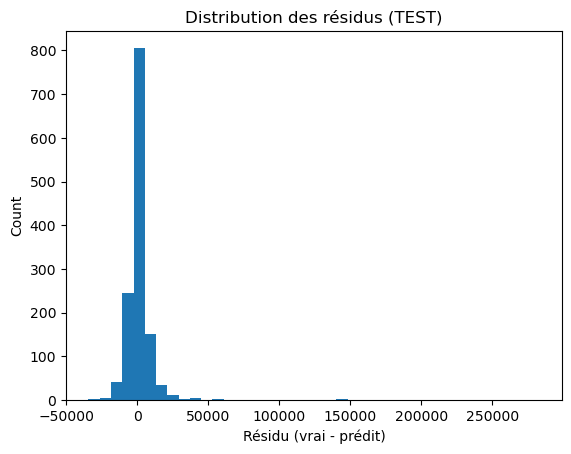

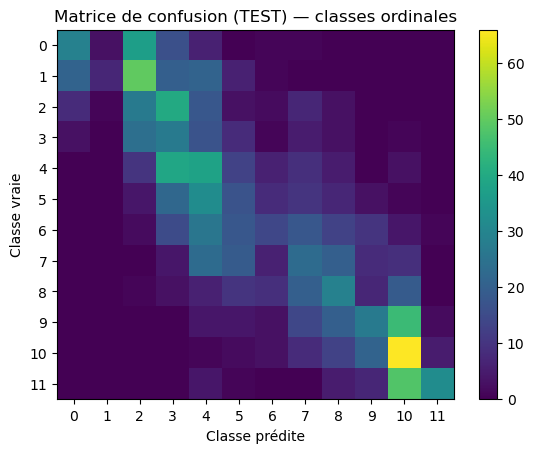

<Figure size 640x480 with 0 Axes>

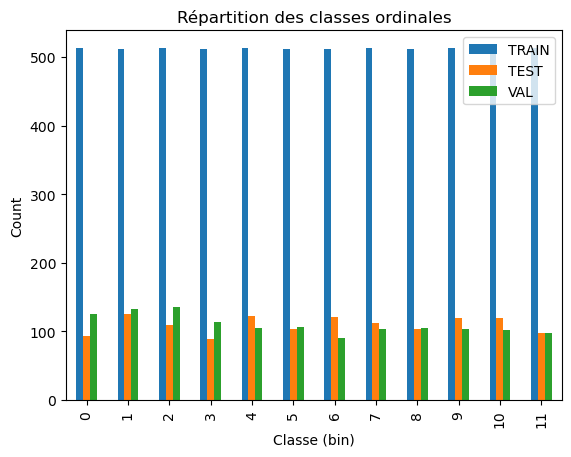

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

from sklearn.metrics import confusion_matrix, mean_absolute_error, r2_score

# ---------- 0) Sécurité : vérifier que les variables clés existent ----------
required = [
    "K", "bin_edges", "class_median",
    "y_train", "y_test2", "y_pred_test", "y_val2", "y_pred_val",
    "y_test_cls", "cls_pred_test", "y_val_cls", "cls_pred_val",
]
missing = [v for v in required if v not in globals()]
if missing:
    print("Variables manquantes :", missing)
    print("→ Relance les cellules du notebook dans l'ordre (de haut en bas).")
else:
    # ---------- 1) Rappel : que signifient les deux familles de métriques ? ----------
    print("=== Comment lire les résultats ===")
    print("- Régression reconstruite : on prédit une CLASSE (bin), puis on reconstruit une conso continue (médiane du bin).")
    print("  → MAE/RMSE/R² évaluent cette conso reconstruite (valeur continue).")
    print("- Ordinal pur : on évalue directement la CLASSE prédite.")
    print("  → MAE rang = |classe vraie - classe prédite| ; Acc ±1 = % à 1 classe près.")
    print()

    # ---------- 2) Baseline (modèle nul) ----------
    y_pred_base_test = np.full_like(y_test2.values, y_train.median(), dtype=float)
    y_pred_base_val  = np.full_like(y_val2.values,  y_train.median(), dtype=float)

    # ---------- 3) Tableau métriques (TEST / VAL) ----------
    def rmse_np(y_true, y_pred):
        return np.sqrt(np.mean((np.asarray(y_true) - np.asarray(y_pred))**2))

    def metrics_reg(y_true, y_pred):
        return {
            "MAE": float(mean_absolute_error(y_true, y_pred)),
            "RMSE": float(rmse_np(y_true, y_pred)),
            "R2": float(r2_score(y_true, y_pred)),
        }

    def metrics_ord(y_cls_true, y_cls_pred, K):
        err = np.abs(np.asarray(y_cls_true) - np.asarray(y_cls_pred))
        return {
            "MAE_rang": float(np.mean(err)),
            "MAE_rang_norm": float(np.mean(err) / max(K-1, 1)),
            "Acc_pm1": float(np.mean(err <= 1)),
        }

    rows = []
    rows.append({"Split":"TEST", "Model":"Baseline (médiane)", **metrics_reg(y_test2, y_pred_base_test)})
    rows.append({"Split":"TEST", "Model":"Ordinal (reconstruit)", **metrics_reg(y_test2, y_pred_test), **metrics_ord(y_test_cls, cls_pred_test, K)})

    rows.append({"Split":"VAL", "Model":"Baseline (médiane)", **metrics_reg(y_val2, y_pred_base_val)})
    rows.append({"Split":"VAL", "Model":"Ordinal (reconstruit)", **metrics_reg(y_val2, y_pred_val), **metrics_ord(y_val_cls, cls_pred_val, K)})

    metrics_df = pd.DataFrame(rows)

    # mise en forme légère
    display_cols = ["Split","Model","MAE","RMSE","R2","MAE_rang","MAE_rang_norm","Acc_pm1"]
    metrics_df = metrics_df.reindex(columns=[c for c in display_cols if c in metrics_df.columns])

    print("=== Tableau de résultats ===")
    display(metrics_df)

    # ---------- 4) Tableau des bins (bornes + médiane + effectif train) ----------
    train_bins = pd.cut(y_train, bins=bin_edges, labels=False, include_lowest=True)
    counts = train_bins.value_counts().sort_index()
    bins_df = pd.DataFrame({
        "bin": np.arange(len(bin_edges)-1),
        "lower": bin_edges[:-1],
        "upper": bin_edges[1:],
        "train_count": [int(counts.get(i, 0)) for i in range(len(bin_edges)-1)],
        "class_median": class_median,
    })
    print("\n=== Bins utilisés (définis sur TRAIN) ===")
    display(bins_df)

    # ---------- 5) Plots ----------
    # 5.2 Résidus (TEST)
    residuals = np.asarray(y_test2) - np.asarray(y_pred_test)
    plt.figure()
    plt.hist(residuals, bins=40)
    plt.xlabel("Résidu (vrai - prédit)")
    plt.ylabel("Count")
    plt.title("Distribution des résidus (TEST)")
    plt.show()

    # 5.3 Matrice de confusion ordinal (TEST)
    cm = confusion_matrix(y_test_cls, cls_pred_test, labels=list(range(K)))
    plt.figure()
    plt.imshow(cm, aspect="auto")
    plt.colorbar()
    plt.xlabel("Classe prédite")
    plt.ylabel("Classe vraie")
    plt.title("Matrice de confusion (TEST) — classes ordinales")
    plt.xticks(range(K))
    plt.yticks(range(K))
    plt.show()

    # 5.4 Répartition des classes (TRAIN/TEST/VAL)
    # (pratique pour voir déséquilibre / difficulté par classe)
    y_test_cls_full = pd.cut(y_test, bins=bin_edges, labels=False, include_lowest=True)
    y_val_cls_full  = pd.cut(y_val,  bins=bin_edges, labels=False, include_lowest=True)

    def dist_series(s, K):
        s = pd.Series(s).dropna().astype(int)
        return pd.Series([int((s==i).sum()) for i in range(K)], index=range(K))

    dist = pd.DataFrame({
        "TRAIN": dist_series(train_bins, K),
        "TEST":  dist_series(y_test_cls_full, K),
        "VAL":   dist_series(y_val_cls_full, K),
    })
    plt.figure()
    dist.plot(kind="bar")
    plt.xlabel("Classe (bin)")
    plt.ylabel("Count")
    plt.title("Répartition des classes ordinales")
    plt.show()



## Sélection automatique de K et alpha (ordinal logit)

**Pourquoi K existe ?**  
La régression logistique ordinale ne prédit pas une valeur continue directement : elle prédit une **classe ordonnée** (0…K−1).  
Ici, `K` = **nombre de tranches (bins)** dans lesquelles on découpe la consommation `conso_5_usages_ef`.

- **K petit** (ex. 5–7) : classes plus larges → **plus facile** de bien classer (meilleures métriques ordinales), mais la conso reconstruite est plus “en paliers” (moins précise).
- **K grand** (ex. 10–15) : classes plus fines → meilleure quantification potentielle (conso reconstruite plus précise), mais **classement plus dur** (métriques ordinales ±1 baissent souvent).

On choisit donc K en optimisant une métrique **continue** (MAE/RMSE/R² sur la conso reconstruite) et/ou une métrique **ordinal** (MAE rang / Acc ±1).


In [46]:

import numpy as np
import pandas as pd
import mord
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def eval_pack(y_true_cont, y_pred_cont, y_true_cls, y_pred_cls, K):
    out = {}
    out["mae"] = float(mean_absolute_error(y_true_cont, y_pred_cont))
    out["rmse"] = rmse(y_true_cont, y_pred_cont)
    out["r2"] = float(r2_score(y_true_cont, y_pred_cont))
    out["mae_rank"] = float(np.mean(np.abs(y_true_cls - y_pred_cls)))
    out["acc_pm1"] = float(np.mean(np.abs(y_true_cls - y_pred_cls) <= 1))
    out["mae_rank_norm"] = out["mae_rank"] / max(K-1, 1)
    return out

# Grille à tester
K_list = [5, 7, 10, 12, 15]
alpha_list = [0.1, 0.3, 1.0, 3.0, 10.0]

rows = []

# Prérequis attendus dans le notebook (déjà calculés plus haut) :
# - Xtr, Xte, Xva (matrices preprocess)
# - y_train, y_test, y_val (cibles continues)
# - y_test2, y_val2 (cibles continues filtrées si besoin)
# - preprocess déjà fit sur train (dans ce notebook, Xtr/Xte/Xva existent déjà)
# Ici, on refait seulement le binning + entraînement ordinal.

for K in K_list:
    # Binning sur TRAIN uniquement
    y_train_cls, bin_edges = pd.qcut(y_train, q=K, labels=False, retbins=True, duplicates="drop")
    y_train_cls = y_train_cls.astype(int)

    # Appliquer bornes sur test/val
    y_test_cls = pd.cut(y_test, bins=bin_edges, labels=False, include_lowest=True)
    y_val_cls  = pd.cut(y_val,  bins=bin_edges, labels=False, include_lowest=True)

    # Filtrage NaN éventuels
    test_mask = ~y_test_cls.isna()
    val_mask  = ~y_val_cls.isna()

    Xte2 = Xte[test_mask.values]
    Xva2 = Xva[val_mask.values]

    y_test2 = y_test.loc[test_mask].copy()
    y_val2  = y_val.loc[val_mask].copy()

    y_test_cls2 = y_test_cls.loc[test_mask].astype(int).values
    y_val_cls2  = y_val_cls.loc[val_mask].astype(int).values

    # Reconstruction continue: médiane par classe (train)
    train_bins = pd.cut(y_train, bins=bin_edges, labels=False, include_lowest=True)
    class_median = y_train.groupby(train_bins).median().values  # taille = nb_bins réels

    K_real = len(class_median)

    for alpha in alpha_list:
        model = mord.LogisticAT(alpha=alpha)
        model.fit(Xtr, y_train_cls)

        cls_pred_test = model.predict(Xte2)
        cls_pred_val  = model.predict(Xva2)

        # Conso reconstruite
        y_pred_test = class_median[cls_pred_test]
        y_pred_val  = class_median[cls_pred_val]

        test_metrics = eval_pack(y_test2.values, y_pred_test, y_test_cls2, cls_pred_test, K_real)
        val_metrics  = eval_pack(y_val2.values,  y_pred_val,  y_val_cls2,  cls_pred_val,  K_real)

        rows.append({
            "K": K_real,
            "alpha": alpha,
            "TEST_MAE": test_metrics["mae"],
            "TEST_RMSE": test_metrics["rmse"],
            "TEST_R2": test_metrics["r2"],
            "TEST_MAE_rank": test_metrics["mae_rank"],
            "TEST_Acc_pm1": test_metrics["acc_pm1"],
            "VAL_MAE": val_metrics["mae"],
            "VAL_RMSE": val_metrics["rmse"],
            "VAL_R2": val_metrics["r2"],
            "VAL_MAE_rank": val_metrics["mae_rank"],
            "VAL_Acc_pm1": val_metrics["acc_pm1"],
        })

results = pd.DataFrame(rows).sort_values(["VAL_MAE", "VAL_RMSE", "VAL_R2"], ascending=[True, True, False])

print("Top 10 (trié sur VAL_MAE puis VAL_RMSE)")
display(results.head(10))

best = results.iloc[0]
print("\nMeilleur candidat (selon VAL_MAE):")
print(best.to_string())


Top 10 (trié sur VAL_MAE puis VAL_RMSE)


,K,alpha,TEST_MAE,TEST_RMSE,TEST_R2,TEST_MAE_rank,TEST_Acc_pm1,VAL_MAE,VAL_RMSE,VAL_R2,VAL_MAE_rank,VAL_Acc_pm1
16,12,0.3,5617.695365,16494.823834,0.274715,1.418693,0.617021,5204.846058,13294.668726,0.412442,1.411676,0.608036
14,10,10.0,5729.114742,16494.897365,0.274709,1.177052,0.701368,5254.600682,13325.987071,0.409670,1.158453,0.699014
13,10,3.0,5929.406991,16672.277833,0.259026,1.252280,0.670973,5263.577483,13502.766770,0.393904,1.184230,0.692191
11,10,0.3,5707.382903,16447.926380,0.278834,1.188450,0.686170,5264.407733,13378.699456,0.404991,1.166793,0.685368
17,12,1.0,5845.181231,16569.393857,0.268143,1.433891,0.623860,5280.205004,13353.378654,0.407241,1.404094,0.620925
10,10,0.1,5704.444073,16460.940179,0.277692,1.159574,0.718085,5280.510614,13377.253061,0.405120,1.156179,0.698256
12,10,1.0,5672.257903,16400.306508,0.283004,1.150456,0.714286,5301.423199,13391.594380,0.403843,1.138741,0.708870
20,15,0.1,5781.997758,16500.615456,0.274206,1.793313,0.521277,5306.548863,13537.222641,0.390807,1.749810,0.527672
9,7,10.0,5897.930129,16719.897671,0.254787,0.816109,0.848024,5336.860235,13665.771726,0.379182,0.783169,0.847612
7,7,1.0,5880.275760,16636.773775,0.262179,0.807751,0.846505,5337.704625,13521.201014,0.392248,0.786202,0.844579



Meilleur candidat (selon VAL_MAE):
K                   12.000000
alpha                0.300000
TEST_MAE          5617.695365
TEST_RMSE        16494.823834
TEST_R2              0.274715
TEST_MAE_rank        1.418693
TEST_Acc_pm1         0.617021
VAL_MAE           5204.846058
VAL_RMSE         13294.668726
VAL_R2               0.412442
VAL_MAE_rank         1.411676
VAL_Acc_pm1          0.608036


In [47]:
import numpy as np
import pandas as pd

# --- Choisir une ligne aléatoire dans le TEST (sur les mêmes indices que y_test) ---
rng = np.random.default_rng(42)

# Si tu as filtré y_test via test_mask (y_test2), prends les indices de y_test2 :
idx = rng.choice(y_test2.index)

x_row = X.loc[idx:idx]          # 1 ligne, format DataFrame (important)
y_true = float(y.loc[idx])      # conso vraie

# --- Transformer + prédire classe ---
Xu = preprocess.transform(x_row)
cls_pred = int(ord_model.predict(Xu)[0])

# --- Reconstruire conso prédite (médiane du bin) ---
y_pred = float(class_median[cls_pred])

# --- (Optionnel) classe vraie selon tes bins (pour debug) ---
y_true_cls = pd.cut(pd.Series([y_true]), bins=bin_edges, labels=False, include_lowest=True).iloc[0]
y_true_cls = None if pd.isna(y_true_cls) else int(y_true_cls)

print("=== Démo prédiction sur une ligne aléatoire (TEST) ===")
print("Index:", idx)
print(f"Conso vraie   : {y_true:.2f}")
print(f"Conso prédite : {y_pred:.2f}")
print(f"Erreur (abs)  : {abs(y_true - y_pred):.2f}")
print(f"Classe prédite: {cls_pred}")
print(f"Classe vraie  : {y_true_cls}")


print("\n--- Extrait des caractéristiques (10 premières valeurs non nulles) ---")
s = x_row.iloc[0].dropna()
print(s.head(10).to_string())


=== Démo prédiction sur une ligne aléatoire (TEST) ===
Index: 6581
Conso vraie   : 47966.40
Conso prédite : 19494.45
Erreur (abs)  : 28471.95
Classe prédite: 11
Classe vraie  : 14

--- Extrait des caractéristiques (10 premières valeurs non nulles) ---
type_batiment                                  maison
type_installation_chauffage                individuel
type_installation_ecs                      individuel
hauteur_sous_plafond                              2.5
surface_habitable_logement                      180.0
nombre_niveau_logement                            2.0
code_postal_ban                               29440.0
qualite_isolation_enveloppe              insuffisante
type_energie_principale_chauffage    Fioul domestique


In [48]:
print("\n--- Extrait des caractéristiques (10 colonnes non-null si possible) ---")
s = x_row.iloc[0]
non_null = s.dropna()
print(non_null.head(10).to_string())



--- Extrait des caractéristiques (10 colonnes non-null si possible) ---
type_batiment                                  maison
type_installation_chauffage                individuel
type_installation_ecs                      individuel
hauteur_sous_plafond                              2.5
surface_habitable_logement                      180.0
nombre_niveau_logement                            2.0
code_postal_ban                               29440.0
qualite_isolation_enveloppe              insuffisante
type_energie_principale_chauffage    Fioul domestique
